In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-23 18:41:54--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.04s   

2023-10-23 18:41:54 (30.6 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [3]:
df = pd.read_csv('housing.csv')

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
df = df[(df.ocean_proximity=='<1H OCEAN') | (df.ocean_proximity=='INLAND')]

In [11]:
df = df.fillna(0)

In [15]:
df.median_house_value = np.log1p(df.median_house_value)

<Axes: xlabel='median_house_value', ylabel='Count'>

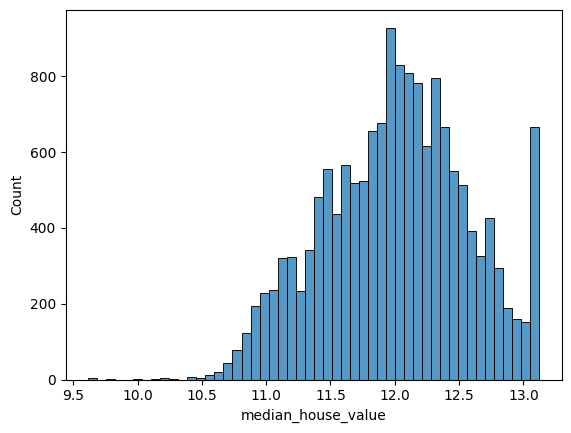

In [18]:
sns.histplot(df.median_house_value,bins = 50)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [20]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [26]:
y_train = df_train.median_house_value
y_val = df_val.median_house_value
y_test = df_test.median_house_value

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [30]:
train_dicts = df_train.to_dict(orient = 'records')
val_dicts = df_val.to_dict(orient = 'records')

In [28]:
dv = DictVectorizer(sparse = True)
X_train = dv.fit_transform(train_dicts)

In [35]:
dt = DecisionTreeRegressor(max_depth = 1)
dt.fit(X_train,y_train)
X_val = dv.transform(val_dicts)
y_pred = dt.predict(X_val)

In [38]:
print(export_text(dt, feature_names = list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [40]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs = -1)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [44]:
y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred, squared = False)
rmse

0.24495290030597153

In [46]:
from tqdm import tqdm

In [47]:
scores = []
for n in tqdm(range(10, 200, 10)):
  rf = RandomForestRegressor(n_estimators = n, random_state = 1)
  rf.fit(X_train,y_train)

  y_pred = rf.predict(X_val)
  rmse = mean_squared_error(y_val, y_pred, squared = False)
  scores.append((n,rmse))
df_score = pd.DataFrame(scores, columns = ['n_estimators','rmse'])

100%|██████████| 19/19 [14:36<00:00, 46.11s/it]


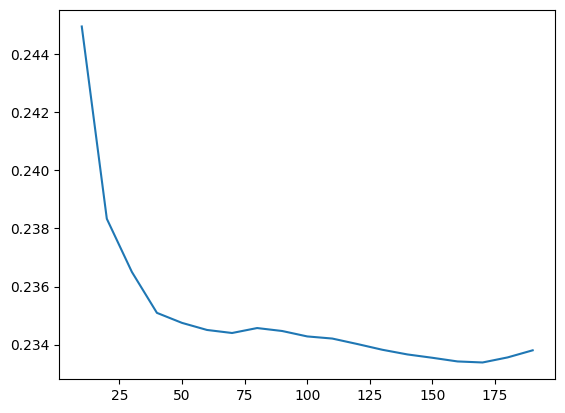

In [48]:
plt.plot(df_score.n_estimators, df_score.rmse)

In [51]:
df_score.round(3)

,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.237
3,40,0.235
4,50,0.235
5,60,0.235
6,70,0.234
7,80,0.235
8,90,0.234
9,100,0.234


In [60]:
max_depth = [10,15,20,25]
scores = []
for d in max_depth:
  for n in tqdm(range(10, 200, 10)):
    rf = RandomForestRegressor(n_estimators = n, random_state = 1,max_depth = d, n_jobs = -1)
    rf.fit(X_train,y_train)

    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared = False)
    scores.append((d,n,rmse))
df_score = pd.DataFrame(scores, columns = ['max_depth','n_estimators','rmse'])

100%|██████████| 19/19 [11:11<00:00, 35.35s/it]


In [61]:
df_score.groupby('max_depth')['rmse'].mean()

max_depth
10    0.245478
15    0.236013
20    0.235354
25    0.234959
Name: rmse, dtype: float64

In [63]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

Text(0.5, 1.0, 'Feature Importance Chart')

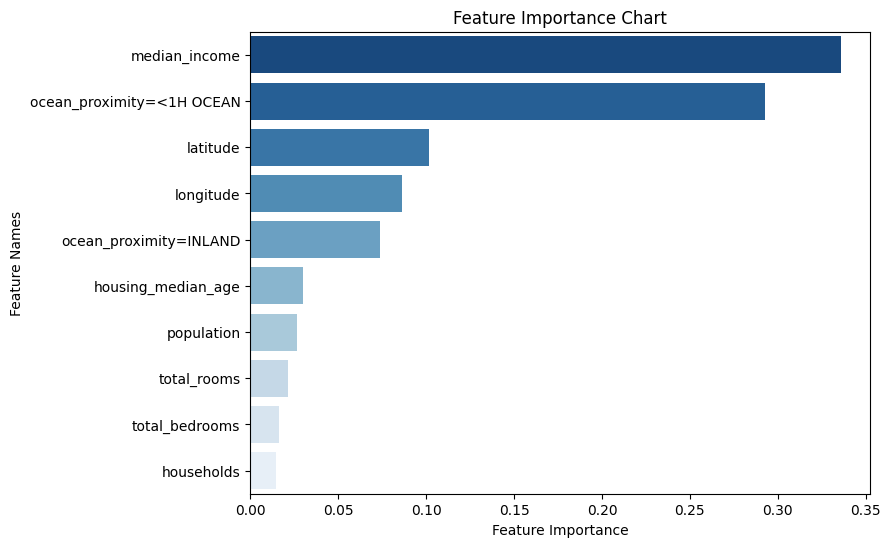

In [65]:
features_names = list(dv.get_feature_names_out())
feature_importances = list(zip(features_names, rf.feature_importances_))

importance_df = pd.DataFrame(feature_importances, columns=['feature_names', 'feature_importances'])

importance_df = importance_df.sort_values(by='feature_importances', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='feature_importances', y='feature_names', data=importance_df, palette='Blues_r')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance Chart')


In [66]:
import xgboost as xgb

In [72]:
features = list(dv.get_feature_names_out())
features= [i.replace("=<", "_").replace("=","_") for i in features]
features

['households',
 'housing_median_age',
 'latitude',
 'longitude',
 'median_income',
 'ocean_proximity_1H OCEAN',
 'ocean_proximity_INLAND',
 'population',
 'total_bedrooms',
 'total_rooms']

In [73]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = features)
dval = xgb.DMatrix(X_val, label = y_val, feature_names = features)

In [74]:
watchlist = [(dtrain,'train'),(dval,'val')]

In [88]:
%%capture output
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params,dtrain,num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [89]:
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val,y_pred,squared = False)
rmse.round(3)

0.229

In [85]:
%%capture output
xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params,dtrain,num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [87]:
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val,y_pred,squared = False)
rmse.round(3)

0.232